In [1]:
import itertools
from operator import itemgetter

import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')

import matplotlib 
import geopy.distance
import matplotlib.pyplot as plt
from math import sqrt
SPINE_COLOR = 'gray'

In [2]:
%matplotlib inline

In [3]:
fig_width_pt = 345/2  # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
# golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
# fig_height =fig_width*golden_mean       # height in inches
fig_height =fig_width
fig_size = [fig_width,fig_height]
fig_size

[2.386882523868825, 2.386882523868825]

In [4]:
from astra.plot.utils import latexify
latexify(2.38,2.38,8)

In [5]:
def ckdnearest(brick_kilns, rivers, gdfB_cols=['geometry']):
    # A = np.vstack([np.array(geom) for geom in brick_kilns[['Longitude','Latitude']].values])
    A = np.vstack([np.array(geom) for geom in brick_kilns[['lon','lat']].values])
    B = [np.array(geom.coords) for geom in rivers.geometry.to_list()] 
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))

    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, river_point_idx = ckd_tree.query(A, k=1)

    closest_river_point = B[river_point_idx]
    river_origin_idx = itemgetter(*river_point_idx)(B_ix)
    gdf = pd.concat(
        [brick_kilns, rivers.loc[river_origin_idx, gdfB_cols].reset_index(drop=True),
         pd.DataFrame(closest_river_point, columns = ['closest_river_point_long','closest_river_point_lat']),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [6]:
waterways_path = '/compliance_analysis/waterways/waterways.shp'
waterways = gpd.read_file(waterways_path)

In [7]:
fp2 = "/India_State_Shapefile/India_State_Boundary.shp"

# Read file using gpd.read_file()
data2 = gpd.read_file(fp2)

In [8]:
def cal_bk_river_dist(path):
    state_bk = pd.read_csv(path)
    bk_river_mapping = ckdnearest(state_bk, waterways)
    bk_river_mapping['distance'] = 0

    for i in range(len(state_bk)):
        bk_river_mapping['distance'][i] = geopy.distance.distance((bk_river_mapping['lat'][i],bk_river_mapping['lon'][i]), (bk_river_mapping['closest_river_point_lat'][i],bk_river_mapping['closest_river_point_long'][i])).km

    return bk_river_mapping

# PUNJAB

In [7]:
bk_river_mapping = cal_bk_river_dist('/exact_latlon/punjab.csv')

In [9]:
latexify(fig_width, fig_height)

In [10]:
fig, ax = plt.subplots(figsize =(3,3))

waterways.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'blue', linewidth = 0.3, label = 'rivers') # river data
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Punjab map

# bk - river distance > 0.5 KM
dist_1 = bk_river_mapping[(bk_river_mapping['distance'] > 0.5)]
ax.scatter(dist_1['lon'],dist_1['lat'], color='green', s=2, marker = 'o', linewidth = 0.5, label = f'{len(dist_1)} brick kilns $>$ 0.5 Km')

# bk - river distance < 0.5 KM
dist_1 = bk_river_mapping[bk_river_mapping['distance'] <= 0.5]
ax.scatter(dist_1['lon'],dist_1['lat'], color='red', s=2, marker = 'o',linewidth = 0.5, label = f'{len(dist_1)} brick kilns $<$ 0.5 Km')

ax.text(76, 32, 'Himachal\n Pradesh')
ax.text(75.5, 31, 'Punjab')
ax.text(74, 29.6, 'Rajasthan')
ax.text(76, 29.6, 'Haryana')

ax.set_xlim(73.5,77)
ax.set_ylim(29.5,32.5)
plt.legend(loc = 'upper left')

ax.set_axis_off()
plt.tight_layout(pad = 0)

plt.savefig('punjab_bk_river.pdf', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('punjab_bk_river.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

# HARYANA

In [9]:
bk_river_mapping = cal_bk_river_dist('/exact_latlon_obb/haryana.csv')

(714, 714, 4)

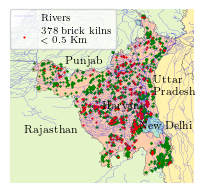

In [46]:
fig, ax = plt.subplots()
latexify(2.38,2.38,8)
waterways.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'blue', linewidth = 0.1, label = 'Rivers') # river data
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Haryana map


# bk - river distance > 0.5 KM
dist_1 = bk_river_mapping[(bk_river_mapping['distance'] > 0.5)]
ax.scatter(dist_1['lon'],dist_1['lat'], color='green', s=1, marker = 'o', linewidth = 0.5)

# bk - river distance < 0.5 KM
dist_1 = bk_river_mapping[bk_river_mapping['distance'] <= 0.5]
ax.scatter(dist_1['lon'],dist_1['lat'], color='red', s=1, marker = 'o',linewidth = 0.5, label = f'{len(dist_1)} brick kilns \n $<$ 0.5 Km')


ax.text(77.1, 29.3, 'Uttar\nPradesh')
ax.text(74.3, 28.5, 'Rajasthan')
ax.text(75.2, 29.9, 'Punjab')
ax.text(76, 29, 'Haryana')
ax.text(76.8, 28.6, 'New Delhi')
ax.set_xlim(74,78) # 4
ax.set_ylim(27.5,31) #3.5

plt.legend(loc = 'upper left',bbox_to_anchor = (0,1), fontsize = 7, borderaxespad = 0)
ax.set_axis_off()

plt.savefig('haryana_bk_river_hi.png',dpi = 300)

im = plt.imread('haryana_bk_river_hi.png')
im.shape

# BIHAR

In [15]:
bk_river_mapping = cal_bk_river_dist('/compass24/exact_latlon/bihar.csv')

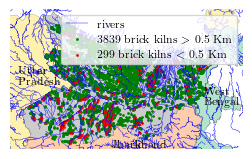

In [16]:
fig, ax = plt.subplots(figsize = (3,3))

waterways.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'blue', linewidth = 0.3, label = 'rivers') # river data
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Bihar map


# bk - river distance > 0.5 KM
dist_1 = bk_river_mapping[(bk_river_mapping['distance'] > 0.5)]
ax.scatter(dist_1['lon'],dist_1['lat'], color='green', s=2, marker = 'o', linewidth = 0.5, label = f'{len(dist_1)} brick kilns $>$ 0.5 Km')

# bk - river distance < 0.5 KM
dist_1 = bk_river_mapping[bk_river_mapping['distance'] <= 0.5]
ax.scatter(dist_1['lon'],dist_1['lat'], color='red', s=2, marker = 'o',linewidth = 0.5, label = f'{len(dist_1)} brick kilns $<$ 0.5 Km')

ax.text(83.2, 25.8, 'Uttar\n Pradesh')
ax.text(85.6, 24.3, 'Jharkhand')
ax.text(86, 26.3, 'Bihar' )
ax.text(88, 25.3, 'West\n Bengal')

ax.set_xlim(83,89)
ax.set_ylim(24.25,27.6)
plt.legend(loc = 'upper right')

ax.set_axis_off()
plt.savefig('bihar_bk_river.pdf', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('bihar_bk_river.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

BRICK KILN HOSPITAL DISTANCE

In [17]:
hospital_df = pd.read_csv('/India_Hospital_Data.csv')
hospital_df = hospital_df.rename(columns = {'lon' : 'Longitude', 'lat' : 'Latitude'})

In [18]:
def ckdnearest_hospital(brick_kilns, hospital_df):
    A = np.vstack([np.array(geom) for geom in brick_kilns[['lon','lat']].values])
    B = np.vstack([np.array(geom) for geom in hospital_df[['Longitude','Latitude']].values] )
    ckd_tree = cKDTree(B)
    dist, hospital_idx = ckd_tree.query(A, k=1)
    closest_hospital_point = B[hospital_idx]
    gdf = pd.concat(
        [brick_kilns,
         pd.DataFrame(closest_hospital_point, columns = ['closest_hospital_long','closest_hospital_lat']),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [19]:
def cal_bk_hosp_dist(path):
    state_bk =pd.read_csv(path)
    bk_hospital_mapping = ckdnearest_hospital(state_bk, hospital_df)
    bk_hospital_mapping['distance_km'] = 0

    for i in range(len(bk_hospital_mapping)):
        bk_hospital_mapping['distance_km'][i] = geopy.distance.distance((bk_hospital_mapping['lat'][i],bk_hospital_mapping['lon'][i]), (bk_hospital_mapping['closest_hospital_lat'][i],bk_hospital_mapping['closest_hospital_long'][i])).km

    return bk_hospital_mapping

PUNJAB

In [20]:
bk_hospital_mapping = cal_bk_hosp_dist('/exact_latlon/punjab.csv')

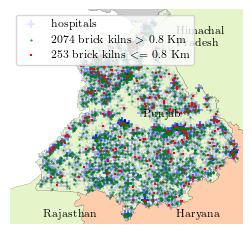

In [21]:
fig, ax = plt.subplots(figsize = (3,3))

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Punjab map

ax.scatter(bk_hospital_mapping['closest_hospital_long'], bk_hospital_mapping['closest_hospital_lat'], color = 'blue', marker = '+', label = 'hospitals', alpha = 0.1 ) #all hospitals
ax.scatter(non_vulnerable_hospital['lon'], non_vulnerable_hospital['lat'],color = 'green', s= 1, marker='.', label = f'{len(non_vulnerable_hospital)} brick kilns $>$ 0.8 Km') # brick kilns
ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'],color = 'red',s=2, marker='|', label = f'{len(vulnerable_hospital)} brick kilns $<=$ 0.8 Km') # brick kilns

ax.text(76, 32, 'Himachal\n Pradesh')
ax.text(75.5, 31, 'Punjab')
ax.text(74, 29.6, 'Rajasthan')
ax.text(76, 29.6, 'Haryana')

ax.set_xlim(73.5,77)
ax.set_ylim(29.5,32.5)
plt.legend(loc = 'upper left')
ax.set_axis_off()

plt.savefig('punjab_bk_hosp.pdf',dpi = 300, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('punjab_bk_hosp.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

HARYANA

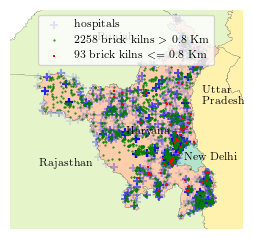

In [22]:
bk_hospital_mapping = cal_bk_hosp_dist('/exact_latlon/haryana.csv')

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]

fig, ax = plt.subplots(figsize = (3,3))

data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Haryana map

ax.scatter(bk_hospital_mapping['closest_hospital_long'], bk_hospital_mapping['closest_hospital_lat'], color = 'blue', marker = '+', label = 'hospitals', alpha = 0.1 ) #all hospitals
ax.scatter(non_vulnerable_hospital['lon'], non_vulnerable_hospital['lat'],color = 'green', s= 1, marker='.', label = f'{len(non_vulnerable_hospital)} brick kilns $>$ 0.8 Km') # brick kilns
ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'],color = 'red',s=2, marker='|', label = f'{len(vulnerable_hospital)} brick kilns $<=$ 0.8 Km') # brick kilns

ax.text(77.3, 29.5, 'Uttar \nPradesh')
ax.text(74.5, 28.5, 'Rajasthan')
ax.text(75.5, 30.5, 'Punjab')
ax.text(76, 29, 'Haryana')
ax.text(77, 28.6, 'New Delhi')

ax.set_xlim(74,78)
ax.set_ylim(27.5,31)
plt.legend(loc = 'upper center')

ax.set_axis_off()
plt.savefig('haryana_bk_hosp.pdf',dpi = 300, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('haryana_bk_hosp.png', dpi = 300)

Bihar

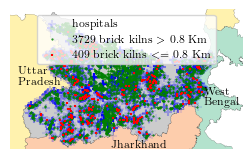

In [23]:
bk_hospital_mapping = cal_bk_hosp_dist('/exact_latlon/bihar.csv')

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]


fig, ax = plt.subplots(figsize= (3,3))

data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Bihar map

ax.scatter(bk_hospital_mapping['closest_hospital_long'], bk_hospital_mapping['closest_hospital_lat'], color = 'blue', marker = '+', label = 'hospitals', alpha = 0.1 ) #all hospitals
ax.scatter(non_vulnerable_hospital['lon'], non_vulnerable_hospital['lat'],color = 'green', s= 1, marker='.', label = f'{len(non_vulnerable_hospital)} brick kilns $>$ 0.8 Km') # brick kilns
ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'],color = 'red',s=2, marker='|', label = f'{len(vulnerable_hospital)} brick kilns $<=$ 0.8 Km') # brick kilns

ax.text(83.2, 25.8, 'Uttar\n Pradesh')
ax.text(85.6, 24.3, 'Jharkhand')
ax.text(86, 26.3, 'Bihar' )
ax.text(88, 25.3, 'West\n Bengal')

ax.set_xlim(83,89)
ax.set_ylim(24.25,27.6)
plt.legend(loc = 'upper center')
ax.set_axis_off()
plt.savefig('bihar_bk_hosp.pdf',dpi = 300, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('bihar_bk_hosp.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

# UTTAR PRADESH

(714, 714, 4)

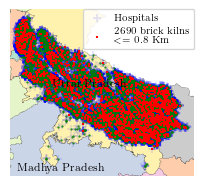

In [45]:
bk_hospital_mapping = cal_bk_hosp_dist('/uttar_pradesh.csv')

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]

fig, ax = plt.subplots()

data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Uttar Pradesh map

ax.scatter(bk_hospital_mapping['closest_hospital_long'], bk_hospital_mapping['closest_hospital_lat'], color = 'blue', marker = '+', label = 'Hospitals', alpha = 0.1 ) #all hospitals
ax.scatter(non_vulnerable_hospital['lon'], non_vulnerable_hospital['lat'],color = 'green', s= 1, marker='.') # brick kilns
ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'],color = 'red',s=1, marker='|', label = f'{len(vulnerable_hospital)} brick kilns \n $<=$ 0.8 Km') # brick kilns

ax.text(78.7, 27.4, 'Uttar Pradesh')
ax.text(77.2, 24, 'Madhya Pradesh')
ax.set_xlim(76.90,84.90) # 8
ax.set_ylim(23.8,30.5) # 6.7

plt.legend(loc = 'upper right',bbox_to_anchor = (1,1), fontsize = 7, borderaxespad = 0)
ax.set_axis_off()
plt.savefig('uttar_pradesh_bk_hosp_hi.png', dpi = 300 )

im = plt.imread('uttar_pradesh_bk_hosp_hi.png')
im.shape